In [6]:
import pickle
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, Dropout, LSTM
from tensorflow.keras import Model

In [2]:
with open('./imgfile.pkl','rb') as arrbee:
    img_list = pickle.load(arrbee)

In [3]:
with open('./labfile.pkl','rb') as lablis:
    lab_list = pickle.load(lablis)

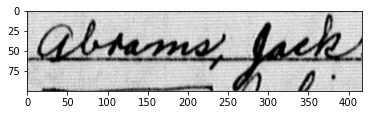

In [13]:
plt.imshow(img_list[0])

In [14]:
img_list[0].shape

(100, 417, 3)

In [21]:
np.all(img_list[0][:,:,0]==img_list[0][:,:,2])

True

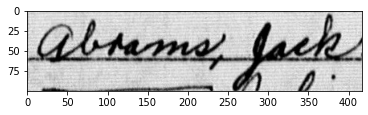

In [28]:
plt.imshow(flat_images[0],cmap='gray')

In [25]:
flat_images = [img[:,:,0] for img in img_list]

In [26]:
flat_images[0]

array([[162, 172, 158, ..., 195, 190, 167],
       [189, 198, 187, ..., 187, 189, 174],
       [205, 220, 207, ..., 199, 211, 201],
       ...,
       [211, 199, 215, ..., 215, 200, 223],
       [185, 198, 210, ..., 230, 229, 223],
       [183, 201, 208, ..., 203, 202, 210]], dtype=uint8)

In [93]:
h,w = img_list[0].shape[:2]
f = min(679/w,480/h)
tx = (679-w*f)/2
ty = (480-h*f)/2
M = np.float32([[f,0,tx],[0,f,ty]])
target = np.ones([480,679])*255
i = cv2.warpAffine(flat_images[0],M, dsize=(679,480), dst=target,borderValue=255) #the presented nanonets used 
#borderMode =cv2.BORDER_TRANSPARENT, which looked like a gray that roughly corresponded to the mean of the image as a
#whole. Maybe try that? But this should work fine

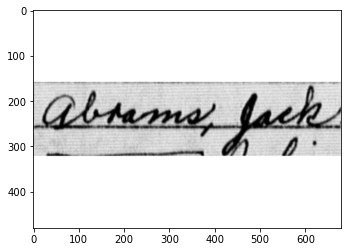

In [94]:
plt.imshow(i,cmap='gray')

In [108]:
def img_fitter(imgs,width,height):
    padded_list = []
    for img in imgs:
        h,w = img.shape #remember to flatten- or if it's still got 3 channels, change to [:2]
        f = min(width/w,height/h)
        tx = (679-w*f)/2
        ty = (480-h*f)/2
        M = np.float32([[f,0,tx],[0,f,ty]])
        target = np.ones([480,679])*255
        padded_list.append(cv2.warpAffine(img,M,dsize=(width,height),dst=target,borderValue=255)/255)
        
    return padded_list
        

In [109]:
padded_list = img_fitter(flat_images,679,480)

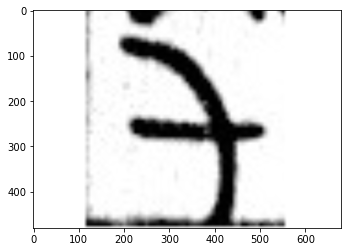

In [113]:
plt.imshow(padded_list[1200],cmap='gray')

In [115]:
lab_list_clean[1200] #Yes, believe it or not

'F'

In [3]:
lab_list_clean = [lab[0] for lab in lab_list]

In [116]:
img_tensor = tf.convert_to_tensor(padded_list)

In [117]:
lab_tensor = tf.convert_to_tensor(lab_list_clean)

In [118]:
with open('./imgtensor.pkl','wb') as re:
    pickle.dump(img_tensor,re)

In [119]:
with open('./labeltensor.pkl','wb') as re:
    pickle.dump(lab_tensor,re)

The image-tensor is *3.6 GB* so be careful with using it

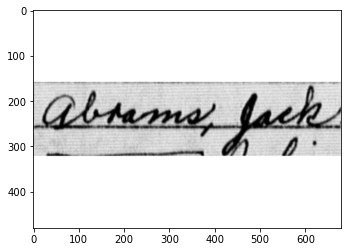

In [125]:
plt.imshow(img_tensor[0],cmap='gray') #seems like it still handles the basics

Here's a question that should be considered for further work- the equivalent of '', that is 'same last name as above' is simple a line in images. And here, it's transcribed as '---' to not mistake it with other dashes and such. But perhaps a different way of encoding it is preferable, something like '@' which isn't found in any other entry, and can be used to call above

https://www.tensorflow.org/api_docs/python/tf/nn/ctc_loss tf says that if you use TPU or GPU (like on Google Colab), you have to use 'dense' tensors with ctc-loss. This base model is based on https://github.com/githubharald/SimpleHTR/tree/master/src which uses sparse tensors, which shouldn't be a problem. In any case, the point isn't to simply mindlessly copy one model, but to iterate on it

In [140]:
max([len(lab) for lab in lab_list_clean])

37

In [143]:
[lab for lab in lab_list_clean if len(lab) ==37]

['Installs + Services Automatic Heaters']

In [14]:
charlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890'

In [26]:
lab_list_clean = [lab.strip() for lab in lab_list_clean]

In [51]:
lab_list_vec = [[charlist.index(letter)+1 for letter in lab]for lab in lab_list_clean] 
#need to add the 0 char at the end

In [53]:
lab_list_vpad = [lab + [0]*(37-len(lab)) for lab in lab_list_vec]

In [60]:
lab_length = [len(lab) for lab in lab_list_vec]

In [55]:
lab_tensor = tf.convert_to_tensor(lab_list_vpad)

In [57]:
with open('./labeltensor.pkl','wb') as lab:
    pickle.dump(lab_tensor,lab)

In [61]:
lab_length = tf.convert_to_tensor(lab_length)

In [65]:
def to_charint(label_list,charlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890',max_chars=37):
    #returns lists, convert to tensor at will
    label_list = [lab.strip() for lab in label_list]
    label_vec = [[charlist.index(letter)+1 if letter in charlist else len(charlist)+1 for letter in lab] for lab in label_list]
    label_pad = [lab + [0]*(max_chars-len(lab)) for lab in label_vec]
    lab_length = [len(lab) for lab in label_vec]
    return label_pad,lab_length
    

In [68]:
lab_tensor,lab_length

(<tf.Tensor: shape=(1407, 37), dtype=int32, numpy=
 array([[ 1, 28, 44, ...,  0,  0,  0],
        [ 8, 31, 27, ...,  0,  0,  0],
        [23,  0,  0, ...,  0,  0,  0],
        ...,
        [64,  0,  0, ...,  0,  0,  0],
        [58, 62,  0, ...,  0,  0,  0],
        [58, 63,  0, ...,  0,  0,  0]])>,
 <tf.Tensor: shape=(1407,), dtype=int32, numpy=array([11,  4,  1, ...,  1,  2,  2])>)

In [72]:
lab_vec_ragged = tf.ragged.constant(lab_list_vec)

In [7]:
with open('./labeltensor.pkl','rb') as elltee:
    lab_tensor = pickle.load(elltee)

In [8]:
lab_tensor

<tf.Tensor: shape=(1407, 37), dtype=int32, numpy=
array([[ 1, 28, 44, ...,  0,  0,  0],
       [ 8, 31, 27, ...,  0,  0,  0],
       [23,  0,  0, ...,  0,  0,  0],
       ...,
       [64,  0,  0, ...,  0,  0,  0],
       [58, 62,  0, ...,  0,  0,  0],
       [58, 63,  0, ...,  0,  0,  0]])>

In [9]:
with open('./imgtensor.pkl','rb') as arrbee:
    img_tensor = pickle.load(arrbee)

In [17]:
l_list = [lab.numpy() for lab in lab_tensor]

In [19]:
i_list = [img.numpy() for img in img_tensor]

In [32]:
i_list.index(i_list[0])

0

In [50]:
np.array_equal(i_list[0],img_tensor[0].numpy())

True

In [44]:
i_list[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

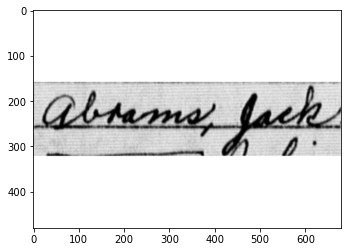

In [22]:
plt.imshow(i_list[0],cmap='gray')

In [13]:
# <!-- ds_image = tf.data.Dataset.from_tensor_slices((img_tensor,lab_vec_ragged))

# ds_image.element_spec

# import tensorflow_datasets as tfds
# import pandas as pd

# ds_image.take(10)

# ds_shuffle = tf.data.Dataset.shuffle(ds_image,seed=815,buffer_size=1500)

# taken from https://keras.io/examples/audio/ctc_asr/ -->

#turned out to be all useless

In [110]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

https://keras.io/guides/functional_api/ used to understand functional api

In [112]:
input_img = Input(shape=(480,679,1),name='image',dtype="float32")
#labels = Input(shape=None,name='label',dtype="int32") #we're using ragged tensors, so no set shape

x = Conv2D(32,(3,3),activation='relu',name='Conv1')(input_img)
x = MaxPooling2D((2,2), name = "pool1")(x)

x = Conv2D(64,(3,3),activation='relu',name='Conv2')(x)
x = MaxPooling2D((2,2), name = "pool2")(x)

shape = ((480//4)-2,((679//4)-1)*64)

x = Reshape(target_shape=shape, name = 'reshape')(x)
x = Dense(64, activation='relu', name ='dense1')(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128,return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)

output = Dense(len(charlist)+1,activation='softmax',name='dense2')(x)
model = Model(input_img,output,name='basic-OCR')
model.compile(optimizer='adam',loss=CTCLoss)




In [113]:
model.summary()

Model: "basic-OCR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 480, 679, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 478, 677, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 239, 338, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 237, 336, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 118, 168, 64)      0         
                                                                 
 reshape (Reshape)           (None, 118, 10752)        0         
                                                                 
 dense1 (Dense)              (None, 118, 64)           68

In [37]:
# dict_imgtolab = {img_tensor[i].ref():lab_vec_ragged[i].ref() for i in range(len(img_tensor))}

# https://www.tensorflow.org/api_docs/python/tf/Tensor and https://www.tensorflow.org/api_docs/python/tf/random/shuffle

# img_tensor.numpy()[0] 
#also useless

In [114]:
eps = 5
history = model.fit(img_tensor_sh,lab_tensor_shpad,validation_split=0.2,epochs=eps)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'CTCLoss/CTCLoss' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Karthik\AppData\Local\Temp/ipykernel_16228/534530595.py", line 2, in <module>
      history = model.fit(img_tensor_sh,lab_tensor_shpad,validation_split=0.2,epochs=eps)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Karthik\AppData\Local\Temp/ipykernel_16228/4201430732.py", line 10, in CTCLoss
      loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py", line 6583, in ctc_batch_cost
      tf.compat.v1.nn.ctc_loss(
Node: 'CTCLoss/CTCLoss'
Saw a non-null label (index >= num_classes - 1) following a null label, batch: 20 num_classes: 68 labels: 59,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 59
	 [[{{node CTCLoss/CTCLoss}}]] [Op:__inference_train_function_8022753]

In [38]:
img_tensor_sh = tf.random.shuffle(img_tensor,seed=815)

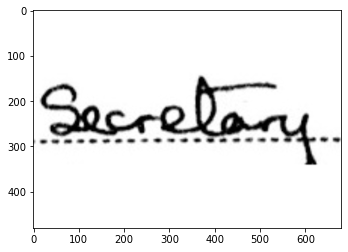

In [41]:
plt.imshow(img_tensor_sh[0].numpy(),cmap='gray')

In [62]:
len(l_list)

1407

In [91]:
%%time
lab_list_sh = []
for i in range(len(i_list)):
    ind = [np.array_equal(img_tensor_sh[i].numpy(),i_list[j]) for j in range(len(i_list))].index(True)
    lab_list_sh.append(l_list[ind])

Wall time: 47min 4s


In [94]:
lab_list_sh[50]

array([ 8, 31, 27, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [74]:
%%time
[np.array_equal(img_tensor_sh[0].numpy(),i_list[i]) for i in range(len(i_list))].index(True)

Wall time: 2.04 s


1073

In [95]:
[charlist[l-1] for l in lab_list_sh[50] if l>0]

['H', 'e', 'a', 'd']

In [98]:
lab_tensor_shpad = tf.convert_to_tensor(lab_list_sh)

In [101]:
lab_vec_sh = [[l for l in lab if l>0] for lab in lab_list_sh]

In [104]:
lab_tensor_sh = tf.ragged.constant(lab_vec_sh)

In [105]:
with open('./labeltensor_sh.pkl','wb') as re:
    pickle.dump(lab_tensor_sh,re)

In [106]:
with open('./labeltensor_shpad.pkl','wb') as ry:
    pickle.dump(lab_tensor_shpad,ry)

In [107]:
with open('./imgtensor_sh.pkl', 'wb') as ra:
    pickle.dump(img_tensor_sh,ra)